In this note book we will attempt to classify a set of neutrino interactions as either CC $\nu_\mu$, CC $\nu_e$ and NC $\nu$ events

In [1]:
import os.path
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.18.0


The code below downloads the sample of genie neutrino events. It will save the `.png` images to the `images` directory. It contains equal numbers of CC $\nu_\mu$, CC $\nu_e$ and NC $\nu$ interactions.

In [2]:
if not os.path.isfile('images/images.tgz'):
  !mkdir images
  !wget --no-check-certificate 'https://www.hep.phy.cam.ac.uk/~lwhitehead/genie_neutrino_images.tgz' -O images/images.tgz
  !tar -xzf images/images.tgz -C images/

# Work out the number of classes form the directory structure
root_dir = 'images/'
dir_contents = os.listdir(root_dir)
num_classes = sum(os.path.isdir(os.path.join(root_dir, item)) for item in dir_contents)

print('Dataset consists of', num_classes, 'classes')

class_names = ['CC numu', 'CC nue', 'NC']
for c in range(num_classes):
  print('Number of',class_names[c],'images:')
  !ls -1 images/$c/*.png | wc -l

--2025-02-07 09:49:21--  https://www.hep.phy.cam.ac.uk/~lwhitehead/genie_neutrino_images.tgz
Resolving www.hep.phy.cam.ac.uk (www.hep.phy.cam.ac.uk)... 131.111.66.33, 2a05:b400:104:100::500:4221
Connecting to www.hep.phy.cam.ac.uk (www.hep.phy.cam.ac.uk)|131.111.66.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67107234 (64M) [application/x-gzip]
Saving to: ‘images/images.tgz’

images/images.tgz   100%[===================>]  64.00M  14.8MB/s    in 5.7s    

2025-02-07 09:49:28 (11.2 MB/s) - ‘images/images.tgz’ saved [67107234/67107234]

Dataset consists of 3 classes
Number of CC numu images:
10000
Number of CC nue images:
10000
Number of NC images:
10000


This block of code automatically builds the datasets direction from the `images` directory, making use of the folder structure to extract the correct truth label for each image.

Found 30000 files belonging to 3 classes.
Using 24000 files for training.
Found 30000 files belonging to 3 classes.
Using 6000 files for validation.
Image shape = (112, 112, 1)


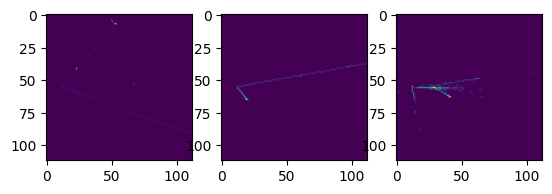

In [3]:
# Batch size is the number of images processed in parallel
batch_size = 32

# The images have actual size 224 x 224, but I am downsampling
# by a factor of two in order to reduce the run time
img_height = 112
img_width = 112

# Let's make use. of tensorflow dataset objects. They let us
# create a dataset from a directory of images
train_ds = tf.keras.utils.image_dataset_from_directory(
  'images',
  validation_split=0.2,
  subset="training",
  seed=42,
  color_mode="rgb",
  label_mode="categorical",
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'images',
  validation_split=0.2,
  subset="validation",
  seed=42,
  color_mode="rgb",
  label_mode="categorical",
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# These images have all three views stacked. For simplicity extract the w view
def extract_w_channel(image, label):
    w_channel = image[:, :, :, 2]
    # Reshape to add a channel dimension
    w_channel = tf.expand_dims(w_channel, axis=-1)
    return w_channel, label

# Apply the function to the dataset
train_ds = train_ds.map(extract_w_channel)
val_ds = val_ds.map(extract_w_channel)

img_shape = None
for images, _ in train_ds.take(1):
    img_shape = images[0].numpy().shape
    print("Image shape =", img_shape)
    n_plots=3
    fig, ax = plt.subplots(1, n_plots)
    for plot_number in range (0, n_plots):
        ax[plot_number].imshow(images[plot_number])


Now you can go ahead and make a CNN as we did in the first tutorial. Feel free to use the architecture that you used in the first tutorial as a base - the comments below follow that architecture

In [ ]:
# Create your CNN model here
input_layer = keras.layers.Input(img_shape)
# First layer: 2D convolution with 32 filters of size (3,3) and relu activation
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(input_layer)
# Second layer: 2D max pooling layer to downsample by a factor of 2 in both dimensions
x = tf.keras.layers.MaxPooling2D((2,2))(x)
# Third layer: dropout with 25% of neurons disabled
x = None(...)(x)
# Fourth layer: flatten the output into 1D for input to a dense layer
x = None(...)(x)
# Fifth layer: dense layer for classification into the number of classes
x = None(...)(x)
cnn_model = keras.Model(input_layer, x)
cnn_model.summary()

In [ ]:
# Compile the model and set up the optimise and loss function required
learning_rate = 0.001
optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
cnn_model.compile(optimizer=optimiser, loss=loss_fn, metrics=["accuracy"])

Now let's train the CNN and see how it does

In [ ]:
cnn_model.fit(train_ds, validation_data=val_ds, epochs=1,
          verbose=1, batch_size=batch_size)

A quick function to get the indices of events that were wrongly classified

In [ ]:
# Make a list of incorrect classifications
def get_incorrect_classifications(model, dataset):
  incorrect_indices = []

  batch_ds = dataset.take(5)

  for images, labels in batch_ds:
    predictions = model.predict(images)

    for i in range(len(labels)):
      prediction = np.argmax(predictions[i])
      truth = np.argmax(labels[i])
      if prediction != truth:
        incorrect_indices.append([images[i], prediction, truth])

  print('Number of images that were incorrectly classified =',len(incorrect_indices))
  return incorrect_indices

Function to draw a wrongly classified event so that we can have a look at it

In [ ]:
# Now you can modify this part to draw different images from the failures list
# You can change the value of im to look at different failures
def draw_event(incorrect_indices, index):
  image_to_plot = incorrect_indices[index][0]
  image_to_plot = np.clip(image_to_plot, 0.0, 50.0)
  fig, ax = plt.subplots(1, 1)
  print('Incorrect classification for image',index,
        ': predicted =',incorrect_indices[index][1],
        'with true =',incorrect_indices[index][2])
  ax.imshow(image_to_plot)

In [ ]:
# Get the failures
incorrect_indices = get_incorrect_classifications(cnn_model, val_ds)

In [ ]:
# Let's have a look at the failures
draw_event(incorrect_indices, 0)